In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from datetime import datetime

In [4]:
def star_maker(image_size, pixel_size_mas, star_radius_mas, star_peak_br, noise_level, spot_peak_brs, spot_positions, spot_std_devs, star_RA_deg=0.0, star_DEC_deg=0.0):
    '''
    Function to create a model star image with added noise and multiple Gaussian spots.
    '''

    # Convert stellar radius to pixels
    star_radius = star_radius_mas / pixel_size_mas

    # Create an empty image with zeros
    star_image = np.zeros((image_size, image_size))

    # Calculate the center coordinates of the star in the image
    center_x, center_y = image_size // 2, image_size // 2

    # Generate a grid of coordinates within the star disc
    x, y = np.meshgrid(np.arange(image_size), np.arange(image_size))

    # Calculate RA and DEC offsets for each pixel
    ra_offsets = (x - center_x) * pixel_size_mas
    dec_offsets = (y - center_y) * pixel_size_mas

    # Calculate the distance of each pixel from the center pixel in mas
    distances = np.sqrt(ra_offsets**2 + dec_offsets**2)

    # Create the star image with the uniform disc model
    star_image[distances <= star_radius] = star_peak_br

    # Add Gaussian noise to the image, in the region within the stellar radius.
    # FIXME: Is this required???
    noise = np.random.normal(0, noise_level, star_image.shape)
    noise[distances >= star_radius] = 0.0
    star_image_with_noise = star_image + noise

    # Add Gaussian spots to the star image
    for idx, spot_peak_br in enumerate(spot_peak_brs):
        if spot_positions[idx] == 'random':
            radius_factor = 0.4
            spot_x = np.random.randint(center_x - radius_factor * star_radius, center_x + radius_factor * star_radius)
            spot_y = np.random.randint(center_y - radius_factor * star_radius, center_y + radius_factor * star_radius)
        else:
            spot_x = center_x + spot_positions[idx][0] / pixel_size_mas
            spot_y = center_y + spot_positions[idx][1] / pixel_size_mas

        # Create a 2D Gaussian kernel for the spot
        spot = spot_peak_br * np.exp(-((x - spot_x)**2 + (y - spot_y)**2) / (2 * spot_std_devs[idx]**2))

        # Add the Gaussian spot to the star image
        star_image_with_noise += spot

    # Plot the beam convolved image
    fig, ax = plt.subplots()
    im = ax.imshow(star_image_with_noise, cmap='hot', extent=[ra_offsets.min(), ra_offsets.max(), dec_offsets.min(), dec_offsets.max()], origin='lower')
    ax.set_xlabel('RA Offset (mas)')
    ax.set_ylabel('DEC Offset (mas)')

    # Draw gridlines at the input star radius
    ax.axhline(y=-star_radius_mas/pixel_size_mas, color='w', linestyle='--', linewidth=0.5)
    ax.axhline(y=star_radius_mas/pixel_size_mas, color='w', linestyle='--', linewidth=0.5)
    ax.axvline(x=-star_radius_mas/pixel_size_mas, color='w', linestyle='--', linewidth=0.5)
    ax.axvline(x=star_radius_mas/pixel_size_mas, color='w', linestyle='--', linewidth=0.5)

    # Add a colorbar to the plot
    plt.colorbar(im)

    # Save the plot to a PDF file
    if not os.path.exists('../data/star_images/'):
        os.mkdir('../data/star_images/')
    plt.savefig('../data/star_images/model_star_new.pdf', format='pdf', bbox_inches='tight')

    # Create a FITS header and add CASA specific keywords and values
    header = fits.Header()
    header['SIMPLE'] = True
    header['BITPIX'] = -64
    header['NAXIS'] = star_image_with_noise.ndim
    header['NAXIS1'] = star_image_with_noise.shape[0]
    header['NAXIS2'] = star_image_with_noise.shape[1]
    header['EXTEND'] = True
    header['BTYPE'] = 'Intensity'
    header['OBJECT'] = 'Model star'
    header['BUNIT'] = 'Jy/beam'
    header['EQUINOX'] = 2000.0
    header['RADESYS'] = 'FK5'
    header['CTYPE1'] = 'RA---SIN'
    header['CRVAL1'] = star_RA_deg
    header['CDELT1'] = pixel_size_mas/3.6e6 # mas to degrees
    header['CRPIX1'] = star_image_with_noise.shape[0]/2
    header['CUNIT1'] = 'deg'
    header['CTYPE2'] = 'DEC--SIN'
    header['CRVAL2'] = star_DEC_deg
    header['CDELT2'] = pixel_size_mas/3.6e6 # mas to degrees
    header['CRPIX2'] = star_image_with_noise.shape[1]/2
    header['CUNIT2'] = 'deg'
    header['DATE'] = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')+' CEST'
    header['ORIGIN'] = 'star_maker_model'
    header['COMMENT'] = 'model star image with noise and spot'

    # Save the model star image to the FITS file
    if not os.path.exists('../data/star_fits/'):
        os.mkdir('../data/star_fits/')
    fits_filename = '../data/star_fits/model_star_new.fits'
    hdu = fits.PrimaryHDU(star_image_with_noise, header=header)
    hdu.writeto(fits_filename, overwrite=True)

    return star_image_with_noise, fits_filename

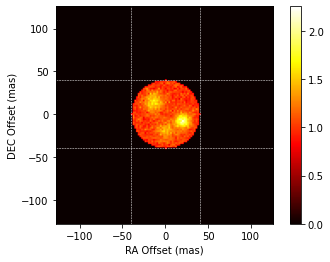

In [5]:
# function inputs
###-----------------------------###
# image parameters
image_size = 128
pixel_size_mas = 2.0
noise_level = 0.1

# star parameters
star_radius_mas = 80
star_peak_br = 1
star_RA_deg=2.27922708E+02
star_DEC_deg=-4.8333058E+01

# spot parameters
spot_positions = ['random', 'random', 'random']
#spot_positions = [(10,10), (5,6), (25,40)]
spot_peak_brs = [1, 0.4, 0.6]
spot_std_devs = [3,4,4]
###-----------------------------###


# function call
###-----------------------------###
star_image_with_noise, fits_filename = star_maker(image_size=image_size, pixel_size_mas=pixel_size_mas, star_radius_mas=star_radius_mas, star_peak_br=star_peak_br, noise_level=noise_level, spot_peak_brs=spot_peak_brs, spot_positions=spot_positions, spot_std_devs=spot_std_devs, star_RA_deg=star_RA_deg,  star_DEC_deg=star_DEC_deg)
###-----------------------------###